### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 10 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 10 мая, -4 балла после 08:30 17 мая, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

**1** - $$-\frac{\partial L(a, y_i)}{\partial a} =2(y_i - a_{i}(x_i))$$ 
**2** -$$-\frac{\partial L(a, y_i)}{\partial a} =y_iexp(-y_ia_{i}(x_i))$$ 
**3** -$$-\frac{\partial L(a, y_i)}{\partial a} =  \frac{y_i}{1 +  exp(-a(x_i) y_i)}$$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

In [137]:
class MyGradientBoostingClassifier:
    def __init__(self, loss='mse', learning_rate=0.5, n_estimators=100, colsample=0.5, subsample=0.5, *args, **kwargs):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.my_trees = []
        self.features = []
        self.colsample = colsample
        self.subsample = subsample
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.args = args
        self.kwargs = kwargs
    
    def mse_target(self, y, predict):
        return 2 * (y - predict).reshape((-1,1))
    
    def exp_target(self, y, predict):
        return y * np.exp(-predict * y)
    
    def log_loss_target(cls, y, predict):
        return y / (1 + np.exp(predict * y))
    
    
    def circle(self, n_estimators, X, a, y,base_model=DecisionTreeRegressor):
        """
        colsample -- процент рандомных признаков при обучнеии одного алгоритма
        subsample -- процент рандомных объектов при обучнеии одного алгоритма
        """
        for i in range(n_estimators):            
            # colsample
            local_colsample = shuffle(list(range(X.shape[1])), random_state=0)
            procent_of_random_features = X.shape[1] * self.colsample
            local_colsample = local_colsample[:round(X.shape[1] * self.colsample)]
            X_f = X[:, local_colsample]
            
            # subsample
            local_subsample = shuffle(list(range(X.shape[0])), random_state=0)
            procent_of_random_objects = X.shape[0] * self.subsample
            local_subsample = local_subsample[:round(X.shape[0] * self.subsample)]
            X_sample = X_f[local_subsample, :]
            
            #append new features
            self.features.append(local_colsample)
            
            
            # y and a
            y_sample = y[local_subsample]
            a_sample = a[local_subsample]
            
            # fit our (y and a)
            model = base_model(*self.args, **self.kwargs)
            if self.loss == 'mse':
                model.fit(X_sample, self.mse_target(y_sample, a_sample))
            if self.loss == 'log':
                model.fit(X_sample, self.log_loss_target(y_sample, a_sample))
            if self.loss == 'exp':
                model.fit(X_sample, self.exp_target(y_sample, a_sample))
            
            self.my_trees.append(model)
            a = a + self.learning_rate * np.asarray(model.predict(X_f))

            
    def fit(self, X, y, base_model=DecisionTreeRegressor, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        self.X = np.array(X)
        self.y = np.array(y)
        if init_model is None:
            a = np.mean(y) * np.ones([y.shape[0]])
        else: 
            model = init_model(*self.args, **self.kwargs)
            model.fit(X, y)  
            
            # my_trees and features appendind
            self.my_trees.append(model)
            self.features.append(list(range(X.shape[1])))
            a = np.array(model.predict(X))
            
        # my_trees appendind model
        self.circle(self.n_estimators, X, a, y, base_model)
                       
        
    def predict(self, X):
        # Ваш код здесь
        a = np.ones([X.shape[0]]) * np.mean(self.y)
        for i in range(len(self.my_trees)):
            a += self.learning_rate * self.my_trees[i].predict(X[:, self.features[i]])
        return np.round(a)



**fit** : Воспользовались shuffle для перемешивания выборки X. Вычленили нужный процент признаков и объектов из полученной выборки -> функция circle (по итерациям)

In [138]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [139]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [140]:
from sklearn.utils import shuffle

In [141]:
my_clf.fit(X_train, y_train)
clf.fit(X_train, y_train)
print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
0.9444444444444444


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [116]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [117]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [118]:
from sklearn.model_selection import train_test_split

In [119]:
import tqdm

In [131]:
range_ = np.arange(1, 100, 10)

train_scores = []
test_scores = []
sklearn_test_score = []

for i in tqdm.tqdm(range_):
    my_clf = MyGradientBoostingClassifier(n_estimators=i, max_depth = 3)
    clf = GradientBoostingClassifier(n_estimators=i, max_depth = 3)
    
    my_clf.fit(X_train, y_train)
    clf.fit(X_train, y_train)
    
    test_scores.append(accuracy_score(y_test, my_clf.predict(X_test)))
    train_scores.append(accuracy_score(y_train, my_clf.predict(X_train)))
    sklearn_test_score.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 10/10 [00:01<00:00,  5.44it/s]


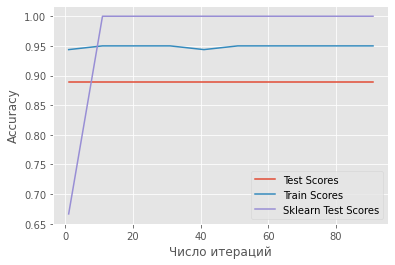

In [136]:
plt.plot(range_, test_scores, label='Test Scores')
plt.plot(range_, train_scores, label='Train Scores')
plt.plot(range_, sklearn_test_score, label='Sklearn Test Scores')
plt.legend()
plt.xlabel('Число итераций')
plt.ylabel('Accuracy')
plt.show()

In [134]:
accuracy = []
for i in tqdm.tqdm(range(1, 150)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    
    # my_clf (init, fit)
    my_clf = MyGradientBoostingClassifier(n_estimators=i)
    my_clf.fit(X_train, y_train)
    
    #accuracy
    accuracy.append(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

100%|██████████| 149/149 [02:33<00:00,  1.03s/it]


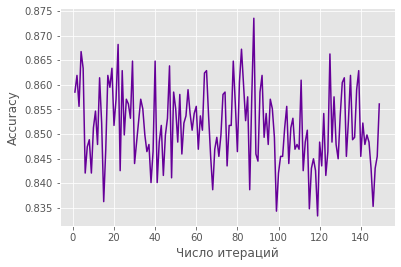

In [135]:
import matplotlib.pyplot as plt
# 1
fig = plt.figure(15)
ax = fig.add_subplot(111)
ax.grid(True)
# 2
N = 150
x = np.arange(1, N, 1)
myhex = '#660099'
# 3
ax.plot(x, accuracy, color=myhex)
plt.xlabel('Число итераций')
plt.ylabel('Accuracy')
plt.show()

In [39]:
np.argmax(test_scores)

9

In [54]:
from itertools import product
shuffle_params = product(
    ('mse', 'exp', 'log'), # loss
    (0.25, 0.5, 0.75, 1), # subsample
    (0.25, 0.5, 0.75, 1), # colsample
    (0.1, 0.3, 0.5)) # learning_rate 

In [55]:
from sklearn.model_selection import train_test_split

from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)
y = (y > 2.0).astype(int)
print(X.shape, y.shape)

(20640, 8) (20640,)


In [59]:
best_estimators = 9
my_accuracy = []
my_params = []
for loss, sub, col, lr in shuffle_params:
    my_params.append([loss, sub, col, lr, best_estimators])
    clf = MyGradientBoostingClassifier(loss =loss, learning_rate=lr, n_estimators=best_estimators,
                                       colsample=col, subsample=sub)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
    clf.fit(X_train, y_train)
    my_accuracy.append(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))

In [60]:
np.max(my_accuracy)

0.8691860465116279

In [61]:
my_params[np.argmax(my_accuracy)]

['mse', 0.75, 0.5, 0.5, 9]

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [62]:
from sklearn.ensemble import RandomForestRegressor
N = 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
my_clf = MyGradientBoostingClassifier('mse', 0.75, 9, 0.5, 0.5, N)
my_clf.fit(X_train, y_train, RandomForestRegressor)
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

0.8624031007751938


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
a = np.ones([X_test.shape[0]]) * np.mean(y_train)
for i in range(N):
    indices = np.random.randint(0, len(y_train), (1, len(y_train)))[0]
    X_samples = X_train[indices, :]
    y_samples = y_train[indices]
    my_clf = MyGradientBoostingClassifier('mse', 0.75, 9, 0.5, 0.5)
    my_clf.fit(X_samples, y_samples, DecisionTreeRegressor)
    a += my_clf.predict(X_test)
a = np.round(a / N)
print(accuracy_score(y_pred=a, y_true=y_test))

0.8832364341085271


Получилось улучшить качество. Мы запустили модель с лучшими коэффициентами, подобранными на предудщем этапе


## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [68]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

**LogisticRegression**


In [69]:
my_clf = MyGradientBoostingClassifier()

In [82]:
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)

In [83]:
my_clf.fit(X_train_scale, y_train, DecisionTreeRegressor, LogisticRegression)

In [84]:
X_test_scale = scaler.transform(X_test)
accuracy_score(y_test, my_clf.predict(X_test_scale))

0.7747093023255814

Качество ухудшилось... :( Зависит от того как будет проиходить шаф, воля случая

**RandomForest**

In [85]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [86]:
my_clf = MyGradientBoostingClassifier()

my_clf.fit(X_train, y_train, DecisionTreeRegressor, RandomForestClassifier)

In [87]:
accuracy_score(y_test, my_clf.predict(X_test))

0.8788759689922481

Качество стало на чуть лучше в случае инициализации при RanodmForest! Наверное потому, что мы на первой итерации получаем более точное решение, ошибки которого нам будет проще исправить

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

Больше практики бы на семинарах( <3


### ВАШ ОТЗЫВ ЗДЕСЬ

